# Hello there!
We always thought it would be cool to give people a way to turn their photos and music into a video slideshow, complete with beat support!

This works by taking an input audio file, performing beat detection, then it syncs up the beats to the images provided.

There are tons of audio processing libraries, but here are a few that we used in this Notebook.
1. [IPython Audio](https://musicinformationretrieval.com/ipython_audio.html)


In [1]:
transition_quantile=0.70
high_pass_accent=0.88
accent_rbg=(0, 127, 255) #255, 127
logo_image_scale=0.6
audio = 'mybeats.wav'
text = "Visit ohack.org"
logo_image = "./Cropped_Pay Blue.png"

In [2]:
import matplotlib.pyplot as plt
import librosa # used to process music files
import IPython.display as ipd # Used to allow Notebooks to play music files
import numpy as np

%matplotlib inline
import librosa.display

# We want larger charts!
plt.rcParams['figure.figsize'] = [20, 10]

# Settings
This is where you set all of the good stuff

In [3]:
picture_directory = "./images"

In [4]:
# read audio file 
x, sr = librosa.load(audio) 
print("Loaded audio file with total duration of %.2f seconds" % librosa.get_duration(y=x, sr=sr))
print("Sample Rate: %d" % sr)
print("Number of frames in sample: %s" % x.shape)
ipd.Audio(x, rate=sr)

# For reference:
## SR = Sampling rate
## X = Length of audio in samples

Loaded audio file with total duration of 8.91 seconds
Sample Rate: 22050
Number of frames in sample: 196542


# Deeper Dive into what the audio looks like

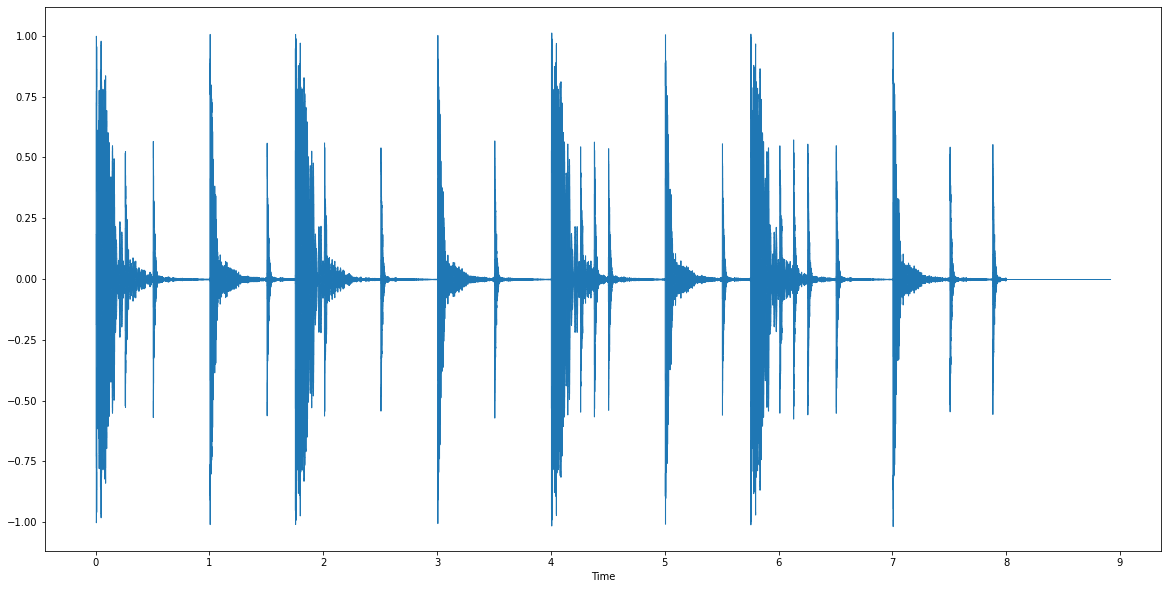

In [5]:
librosa.display.waveshow(x, sr=sr)

## Spectral visualization

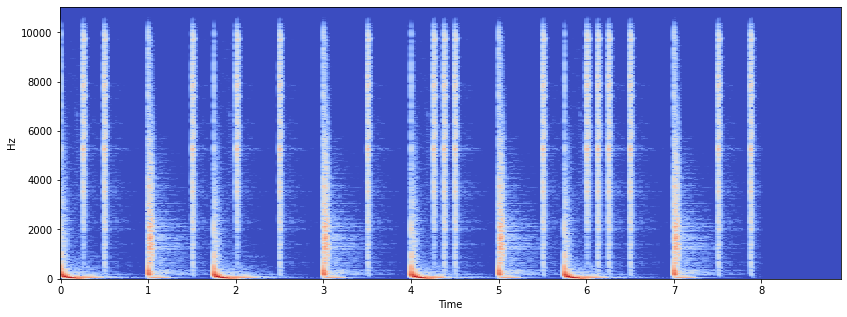

In [6]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

# Declare both high pass and low pass filters

In [7]:
def do_high_pass_filter(data, sr, output_filename):
    from scipy import signal
    cutOff = 6000 # Cutoff frequency
    nyq = 0.5 * sr
    N  = 6    # Filter order
    fc = cutOff / nyq # Cutoff frequency normal
    b, a = signal.butter(N, fc, btype="high")
    tempf = signal.filtfilt(b, a, data)
    
    import soundfile as sf
    sf.write(output_filename, tempf, sr, subtype='PCM_24')


In [8]:
def do_low_pass_filter(data, sr, output_filename):
    from scipy import signal
    cutOff = 850 # Cutoff frequency
    nyq = 0.5 * sr
    N  = 6    # Filter order
    fc = cutOff / nyq # Cutoff frequency normal
    b, a = signal.butter(N, fc, btype="low")
    tempf = signal.filtfilt(b, a, data)
    
    import soundfile as sf
    sf.write(output_filename, tempf, sr, subtype='PCM_24')


# Two methods of beat detection

## Using Librosa (not that great for complex songs)

In [9]:
onset_env = librosa.onset.onset_strength(x, sr=sr, aggregate=np.median)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, tightness=5, start_bpm=60, sr=sr, units="time")

/Users/gregv/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass y=[ 0.00024163 -0.00135583  0.00040048 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


In [10]:
clicks = librosa.clicks(beats, sr=sr, click_duration = 0.9, length=len(x))
clicks

/Users/gregv/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass times=[0.27863946 1.021678   1.76471655 2.53097506 3.04181406 4.01705215
 4.52789116 5.03873016 5.78176871 6.52480726 7.03564626] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [11]:
ipd.Audio(x + clicks, rate=sr)

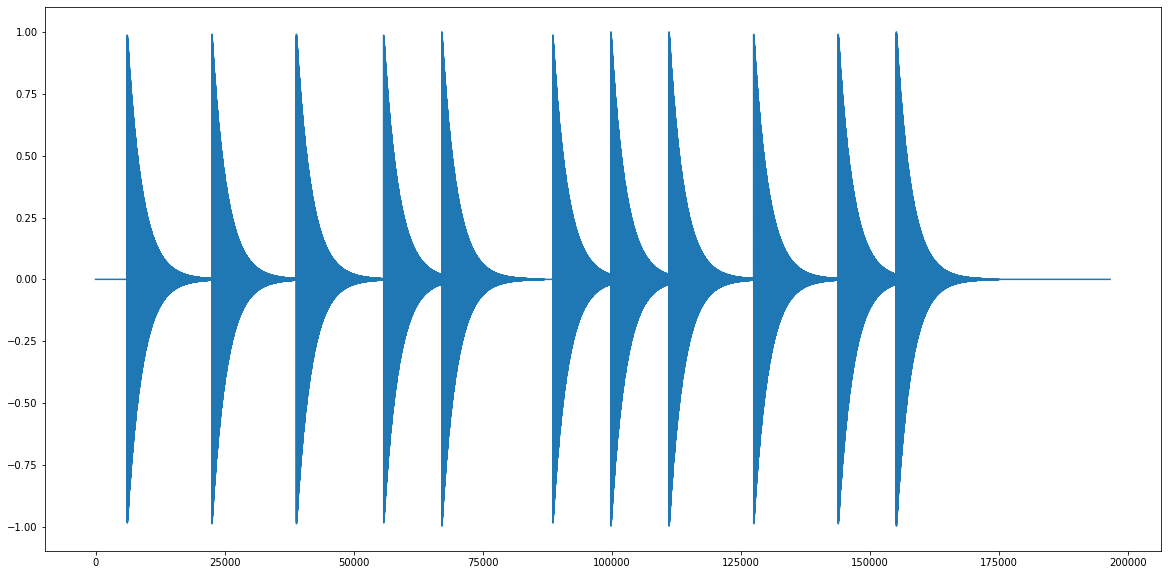

In [12]:
plt.plot(clicks)

## Let's use madmom instead

In [13]:
import madmom 

def madmon_beats(filename):
    x, sr = librosa.load(filename) 

    # I tried this route, but this wasn't very good:
    #proc = madmom.features.beats.BeatTrackingProcessor(fps=100, look_aside=1, look_ahead=1)

    # This is what worked for me
    proc = madmom.features.beats.CRFBeatDetectionProcessor(fps=100, interval_sigma=1)
    act = madmom.features.beats.RNNBeatProcessor()(filename)

    beat_times = proc(act)

    clicks = librosa.clicks(beat_times, click_duration = 2, sr=sr, length=len(x))
    return x, sr, clicks

In [14]:
# We need something to clamp values to 1 or 0 depending on a threshold
def myfunc(value, cutoff_threshold):
    if value > cutoff_threshold:
        return 1.0
    else:
        return 0.0

def get_transform(clicks, threshold_quantile):
    # Set the first cutoff for the non-sampled waveform
    cutoff_threshold = np.quantile( np.abs(clicks), threshold_quantile)
    print("First Cutoff (yellow): %.2lf" % cutoff_threshold)
    overlay = np.array([myfunc(xi,cutoff_threshold) for xi in clicks])
    
    # Resample the waveform to 60 fps
    resampled = librosa.resample(overlay, sr, 60)
    plt.plot(resampled)
    
    # Get the next cutoff for the resampled waveform
    cutoff_threshold = np.quantile( np.abs(resampled), threshold_quantile)    
    print("Second Cutoff (blue): %.2lf" % cutoff_threshold)
    resampled_2 = np.array([myfunc(xi, cutoff_threshold) for xi in resampled])

    plt.plot(resampled_2)
    return resampled_2
    

# DROP THE BEAT

## Normal version (with regular audio, no filters applied)

/Users/gregv/miniconda3/envs/py37/lib/python3.7/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)
/Users/gregv/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Pass times=[0.03 0.51 1.01 1.51 2.02 2.51 3.01 3.51 4.01 4.51 5.01 5.51 6.02 6.51
 7.01 7.5  7.89] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  from ipykernel import kernelapp as app


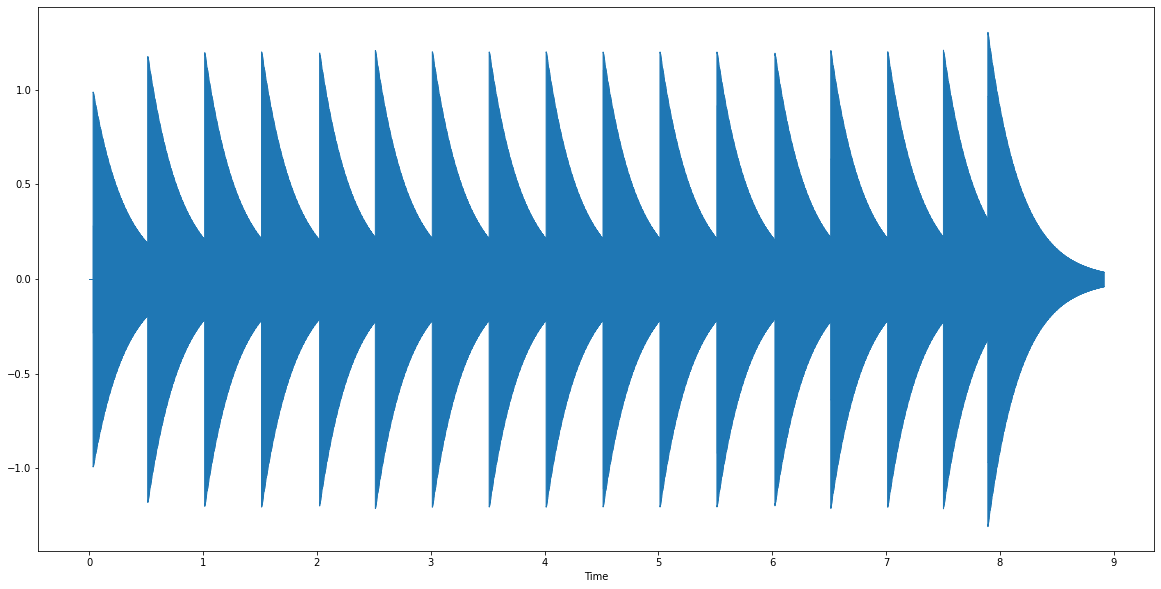

In [15]:
orig_x, orig_sr, clicks = madmon_beats(audio)
librosa.display.waveshow(clicks, sr=orig_sr)
ipd.Audio(orig_x + clicks, rate=orig_sr)

First Cutoff (yellow): 0.44


/Users/gregv/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Pass orig_sr=22050, target_sr=60 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  from ipykernel import kernelapp as app


Second Cutoff (blue): 0.29


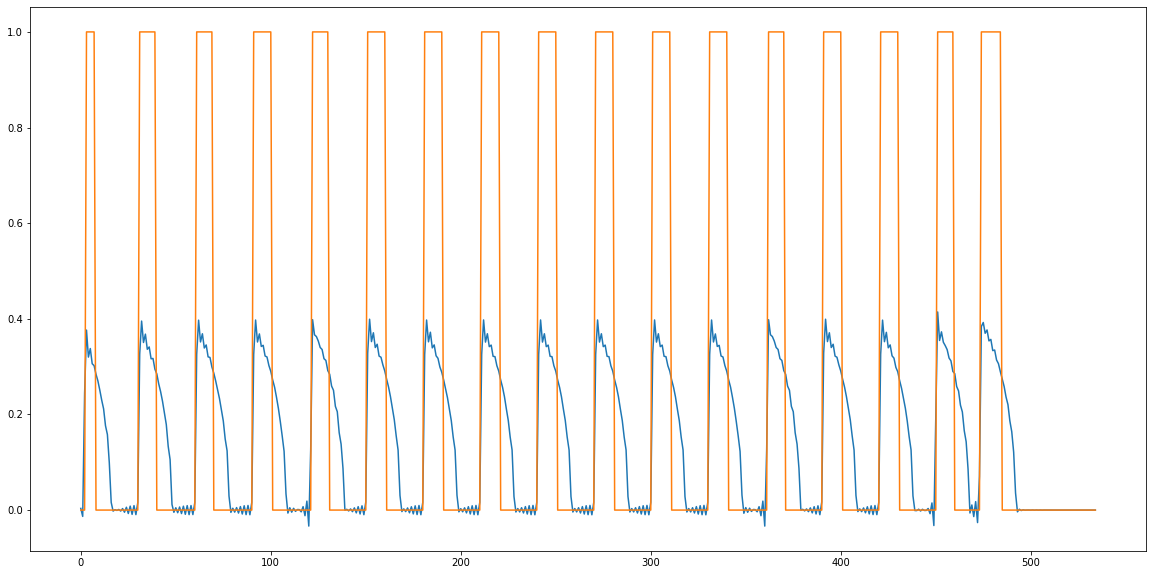

In [16]:
ipd.Audio(orig_x + clicks, rate=orig_sr)
orig_out = get_transform(clicks, transition_quantile)

Any area of the chart that is clamped to 1 will be used to display an image, anything at 0 will not display an image

# High Pass
We do this to establish an "accent" beat that we'll use to color the image differently

/Users/gregv/miniconda3/envs/py37/lib/python3.7/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)
/Users/gregv/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Pass times=[0.03 0.51 1.01 1.51 2.02 2.51 3.01 3.51 4.01 4.51 5.01 5.51 6.02 6.51
 7.01 7.5  7.89] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  from ipykernel import kernelapp as app
/Users/gregv/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Pass times=[0.26 0.52 1.01 1.51 2.02 2.51 3.01 3.51 4.01 4.51 5.01 5.51 6.01 6.51
 7.01 7.5  7.88] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  from ipykernel import kernelapp as app


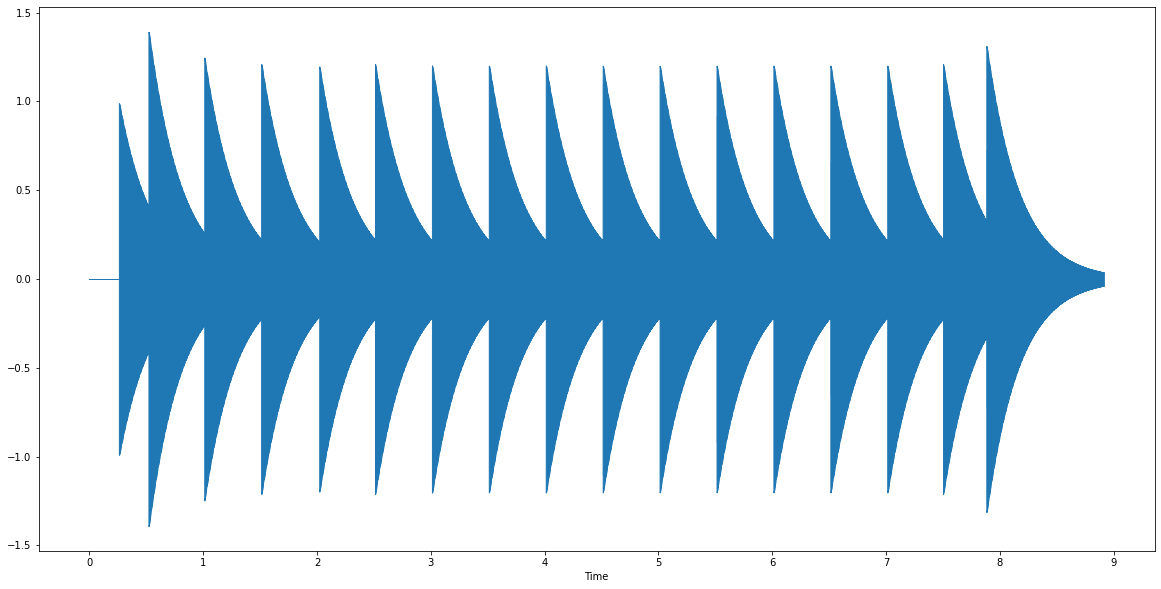

In [17]:
orig_x, orig_sr, clicks = madmon_beats(audio)
do_high_pass_filter(orig_x, orig_sr, "high_pass"+audio)
orig_x, orig_sr, clicks = madmon_beats("high_pass"+audio)
librosa.display.waveshow(clicks, sr=orig_sr)
ipd.Audio(orig_x + clicks, rate=orig_sr)

First Cutoff (yellow): 0.72


/Users/gregv/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Pass orig_sr=22050, target_sr=60 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  from ipykernel import kernelapp as app


Second Cutoff (blue): 0.24


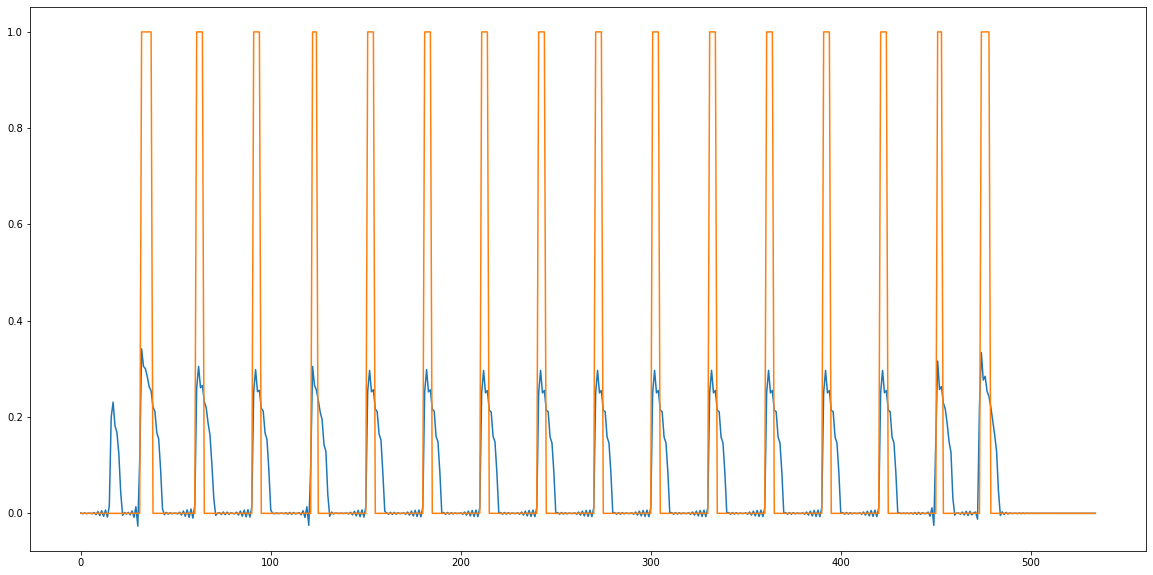

In [18]:
ipd.Audio(orig_x + clicks, rate=orig_sr)
high_pass_out = get_transform(clicks, high_pass_accent)

## Combined regular audio and high-pass filter
We can see that the combined audio files will give us some portions of audio that are accented

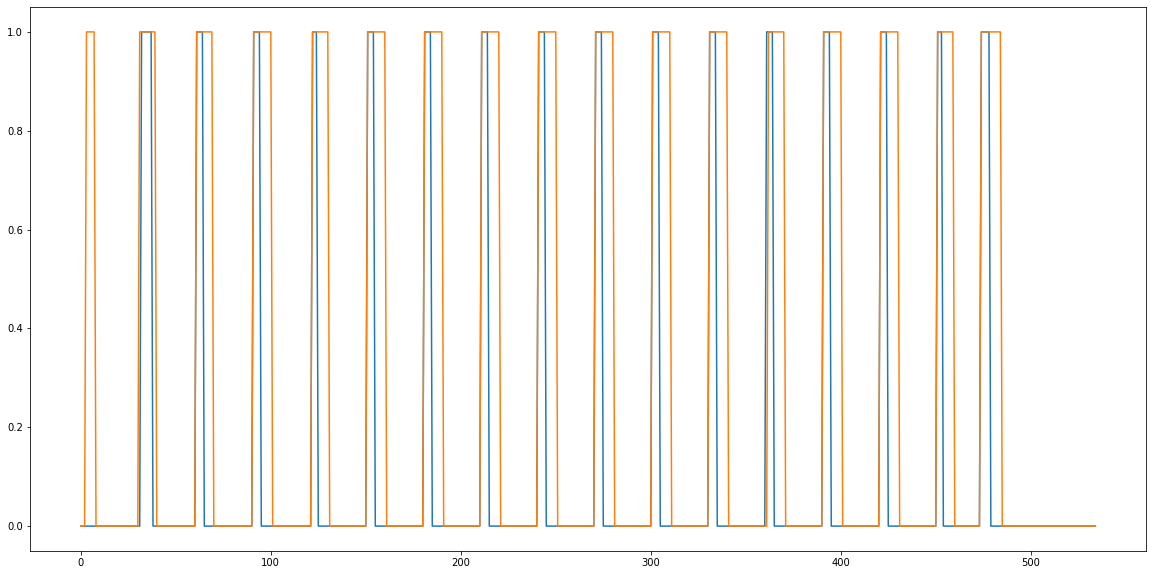

In [19]:
plt.plot(high_pass_out)
plt.plot(orig_out)

# Resize Images to be consistent

In [20]:
# https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/

In [21]:
# importing libraries 
import os 
import cv2  
from PIL import Image  
  
# Checking the current directory path 
print(os.getcwd())  
  
file_dir = os.listdir('./images/')

mean_height = 0
mean_width = 0
  
num_of_images = len(file_dir) 
print(num_of_images) 

for file in file_dir: 
    print(file)

/Users/gregv/dev/automatic-beat-video
18
IMG_4701.JPG
resized
IMG_4738.JPG
.DS_Store
20181101_203106.jpg
IMG_4707.JPG
IMG_4639.JPG
20181101_210300.jpg
20181101_203145.jpg
20181101_205133.jpg
IMG_4744.JPG
IMG_4695.JPG
IMG_4722.JPG
20181101_210412.jpg
IMG_4651.JPG
20181101_204514.jpg
IMG_4653.JPG
IMG_4647.JPG


In [22]:
path = "./images/"

from os.path import join
from glob import glob

files = []
for ext in ('*.gif', '*.png', '*.jpg', '*.JPG'):
   files.extend(glob(join(path, ext)))
print(files)

['./images/20181101_203106.jpg', './images/20181101_210300.jpg', './images/20181101_203145.jpg', './images/20181101_205133.jpg', './images/20181101_210412.jpg', './images/20181101_204514.jpg', './images/IMG_4701.JPG', './images/IMG_4738.JPG', './images/IMG_4707.JPG', './images/IMG_4639.JPG', './images/IMG_4744.JPG', './images/IMG_4695.JPG', './images/IMG_4722.JPG', './images/IMG_4651.JPG', './images/IMG_4653.JPG', './images/IMG_4647.JPG']


In [23]:
for file in files: 
    im = Image.open(file) 
    width, height = im.size 
    mean_width += width 
    mean_height += height 
    # im.show()   # uncomment this for displaying the image 
  
# Finding the mean height and width of all images. 
# This is required because the video frame needs 
# to be set with same width and height. Otherwise 
# images not equal to that width height will not get  
# embedded into the video 
mean_width = int(mean_width / num_of_images) 
mean_height = int(mean_height / num_of_images) 
  
print(mean_height) 
print(mean_width) 
  
# Resizing of the images to give 
# them same width and height  
for file in file_dir: 
    if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".JPG") or file.endswith("png"): 
        # opening image using PIL Image 
        im = Image.open(os.path.join(path, file))  
   
        # im.size includes the height and width of image 
        width, height = im.size    
        print(width, height) 
  
        # resizing  
        imResize = im.resize((mean_width, mean_height), Image.ANTIALIAS)
        try:
            file = file.lower()
            imResize.save( join("./images/resized/",file), 'JPEG', quality = 95) # setting quality 
            # printing each resized image name 
            print(im.filename.split('\\')[-1], " is resized")  
        except:
            print("Cannot resize file %s" % file) 

3254
4709
6000 4000


/Users/gregv/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


./images/IMG_4701.JPG  is resized
6000 4000
./images/IMG_4738.JPG  is resized
4128 3096
./images/20181101_203106.jpg  is resized
6000 4000
./images/IMG_4707.JPG  is resized
6000 4000
./images/IMG_4639.JPG  is resized
4128 3096
./images/20181101_210300.jpg  is resized
4128 3096
./images/20181101_203145.jpg  is resized
4128 3096
./images/20181101_205133.jpg  is resized
6000 4000
./images/IMG_4744.JPG  is resized
6000 4000
./images/IMG_4695.JPG  is resized
6000 4000
./images/IMG_4722.JPG  is resized
4128 3096
./images/20181101_210412.jpg  is resized
6000 4000
./images/IMG_4651.JPG  is resized
4128 3096
./images/20181101_204514.jpg  is resized
6000 4000
./images/IMG_4653.JPG  is resized
6000 4000
./images/IMG_4647.JPG  is resized


# Video Processing

In [24]:
def overlay_transparent(background, overlay, x, y):

    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        return background

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        overlay = np.concatenate(
            [
                overlay,
                np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype) * 255
            ],
            axis = 2,
        )

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

    return background

In [25]:
from os.path import join
from glob import glob
from transforms import RGBTransform # from source code mentioned above
from PIL import Image
import os 
import cv2  
import random

video_name = "video_output.avi"

def get_files():
    path = "%s/resized" % picture_directory
    print(f"Looking for images in: {path}")
    files = []
    for ext in ('*.gif', '*.png', '*.jpg'):
       files.extend(glob(join(path, ext)))
    return random.sample(files, len(files))

def process_video(sampled_waveform, accent_waveform=None):
    path = "%s/resized" % picture_directory

    files = get_files()
    
    if len(files) == 0:
        print("Did not find any image files, exiting")
        return

    output_image_list = []
    image = None
    get_new_image = True
    accent = False
    
    for idx in range(len(sampled_waveform)):
        num = sampled_waveform[idx]
        if len(high_pass_out) > 0 and accent_waveform is not None:
            accent = accent_waveform[idx] > 0
            
        if num > 0:
            if len(files) == 1:
                files.extend(get_files())
                print(files)
                
            if get_new_image:
                image = files.pop()
                if accent:
                    image = "+++ %s" % image
            #print("2 Processing Image: %s" % image)
            get_new_image = False
        else:
            image = None
            get_new_image = True


        output_image_list.append(image)
    
    print("--------------Image List v-----------------------------")
    print(output_image_list)
    print("-----------------Image List ^--------------------------")
    
    first_image_in_list = output_image_list[list(np.nonzero(output_image_list)[0])[0]]
    frame = cv2.imread(first_image_in_list.replace("+++ ",""))

    # setting the frame width, height width 
    # the width, height of first image 
    height, width, layers = frame.shape 
    
    # Setup output video details    
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    replay_framerate = 60 # Frames per second
    color = True
    video = cv2.VideoWriter(video_name, fourcc, replay_framerate, (width, height), color)

    # Create background image with text
    black = np.zeros((height,width,3), np.uint8)
    logo = cv2.imread(logo_image)
    small = cv2.resize(logo, (0,0), fx=logo_image_scale, fy=logo_image_scale) 
    logo_w = small.shape[1]
    logo_h = small.shape[0]

    blank_image = overlay_transparent(
        black, small,
        int( (black.shape[1]-logo_w)/2),
        int( (black.shape[0]-logo_h)/2) )

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 3
    fontColor              = (255,255,255)
    lineType               = 2


    textsize = cv2.getTextSize(text, font, fontScale, 2)[0]
    # get coords based on boundary
    textX = int((blank_image.shape[1] - textsize[0]) / 2)
    textY = int((blank_image.shape[0] + textsize[1]) / 2) + int(logo_h/2) + 100
    bottomLeftCornerOfText = (textX, textY)

    cv2.putText(blank_image, text, 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

    print("---------------Starting video writing----------------------------")

    prev_accent_image_filename = ""
    alpha = 0.00
    
    prev_image_filename = ""
    image_alpha=1.2
    image_beta=0
    
    # Loop through images and create video
    for idx, myimage in enumerate(output_image_list):
        if myimage:   
            if "+++" in myimage:
                myimage = myimage.replace("+++ ", "")
                accent = True
            else:
                accent = False
            print("Writing image %s" % myimage)
            
            
            if accent:
                print("-- Accent detected")
                accent_image = Image.open(myimage)
                accent_image = accent_image.convert('RGB') # ensure image has 3 channels
                
                if prev_accent_image_filename == myimage:
                    # Alpha cutoff at 0.70 to not get any more transparent
                    if alpha >= 0.70:
                        alpha = alpha
                    else:
                        # Increase the transparency
                        alpha = alpha + 0.09
                else:
                    alpha = 0.00

                accent_image = RGBTransform().mix_with(accent_rbg,factor=alpha).applied_to(accent_image)
                video.write(np.array(accent_image))  
                prev_accent_image_filename = myimage
            else:
                image = cv2.imread(myimage)
                if prev_image_filename == myimage:
                    if image_alpha >= 5:
                        image_alpha = image_alpha
                    else:
                        image_alpha = image_alpha + 0.09
                else:
                    image_alpha = 1.2
                adjusted = cv2.convertScaleAbs(image, alpha=image_alpha, beta=0)
                video.write(adjusted)
                prev_image_filename = myimage
        else:
            last_frames = 5
            
            if not accent and prev_image_filename and idx <= len(output_image_list)-last_frames:
                image = cv2.imread(prev_image_filename)
                adjusted = cv2.convertScaleAbs(image, alpha=0.5, beta=0)
                video.write(adjusted)
            else:
                print("Writing black frame")
                video.write(blank_image)

    # Deallocating memories taken for window creation 
    video.release()  # releasing the video generated 

In [26]:
process_video(orig_out, high_pass_out)

Looking for images in: ./images/resized
Looking for images in: ./images/resized
['./images/resized/20181101_203145.jpg', './images/resized/img_4744.jpg', './images/resized/img_4653.jpg', './images/resized/20181101_210300.jpg', './images/resized/img_4639.jpg', './images/resized/img_4647.jpg', './images/resized/img_4722.jpg', './images/resized/img_4651.jpg', './images/resized/20181101_205133.jpg', './images/resized/20181101_204514.jpg', './images/resized/20181101_203106.jpg', './images/resized/img_4707.jpg', './images/resized/20181101_203145.jpg', './images/resized/20181101_210412.jpg', './images/resized/img_4695.jpg', './images/resized/img_4738.jpg', './images/resized/img_4701.jpg']
--------------Image List v-----------------------------
[None, None, None, './images/resized/20181101_203106.jpg', './images/resized/20181101_203106.jpg', './images/resized/20181101_203106.jpg', './images/resized/20181101_203106.jpg', './images/resized/20181101_203106.jpg', None, None, None, None, None, None

---------------Starting video writing----------------------------
Writing black frame
Writing black frame
Writing black frame
Writing image ./images/resized/20181101_203106.jpg
Writing image ./images/resized/20181101_203106.jpg
Writing image ./images/resized/20181101_203106.jpg
Writing image ./images/resized/20181101_203106.jpg
Writing image ./images/resized/20181101_203106.jpg
Writing image ./images/resized/20181101_210412.jpg
Writing image ./images/resized/20181101_210412.jpg
Writing image ./images/resized/20181101_210412.jpg
Writing image ./images/resized/20181101_210412.jpg
Writing image ./images/resized/20181101_210412.jpg
Writing image ./images/resized/20181101_210412.jpg
Writing image ./images/resized/20181101_210412.jpg
Writing image ./images/resized/20181101_210412.jpg
Writing image ./images/resized/20181101_210412.jpg
Writing image ./images/resized/img_4722.jpg
-- Accent detected
Writing image ./images/resized/img_4722.jpg
-- Accent detected
Writing image ./images/resized/img

Writing image ./images/resized/img_4653.jpg
-- Accent detected
Writing image ./images/resized/img_4653.jpg
-- Accent detected
Writing image ./images/resized/img_4653.jpg
-- Accent detected
Writing image ./images/resized/img_4653.jpg
-- Accent detected
Writing image ./images/resized/img_4653.jpg
-- Accent detected
Writing image ./images/resized/img_4653.jpg
-- Accent detected
Writing image ./images/resized/img_4653.jpg
-- Accent detected
Writing image ./images/resized/img_4653.jpg
-- Accent detected
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing image ./images/resized/img_4639.jpg
-- Accent detected
Writing image ./images/resized/im

Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame
Writing black frame


In [27]:
import ffmpy
from datetime import datetime
import tzlocal 
now = datetime.now(tzlocal.get_localzone())

rgb_str = "%s-%s-%s" % (accent_rbg[0], accent_rbg[1], accent_rbg[2])

output_video = "%s__%s_%s__%s.mp4" % (rgb_str,transition_quantile, high_pass_accent, now.strftime('%Y-%m-%d__%H_%M_%S'))

print("audio: %s   video: %s  output: %s" %(audio, video_name, output_video))
ff = ffmpy.FFmpeg(
    inputs={ audio: None, video_name: None},
    outputs={ output_video: None}
)
#print(ff.cmd)        
ff.run()
#ffmpeg -i faster_tempo.wav -i first_test.avi 3.mp4

audio: mybeats.wav   video: video_output.avi  output: 0-127-255__0.7_0.88__2022-07-14__20_43_39.mp4


ffmpeg version 5.0 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.30)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolbox
  lib

(None, None)

In [28]:
# Create a video with just the original beat input but - no accents
#plt.plot(orig_out)

In [29]:
#process_video(orig_out)